# Step 1 - Importing data

In [1]:
import numpy as np
from glob import glob


# load filenames for human and dog images
human_files = np.array(glob("datasets/HumanImages/*/*"))
dog_files = np.array(glob("datasets/DogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


# Step 2 - Detect Humans

Number of faces detected: 1


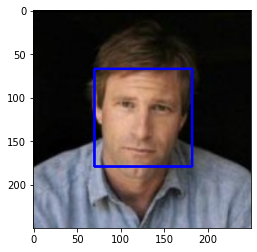

In [2]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

#REMEMBER TO TEST WITH OTHERS CLASSIFIERS TO IMPROVE QUALITY
#haarcascade_frontalface_default.xml
#haarcascade_frontalface_alt2.xml 

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

In [3]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

# IMPLEMENTATION

In [4]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#
## TODO: Test the performance of the face_detector algorithm 
human_files_test= [face_detector(i) for i in human_files_short]
print("Well detected human faces is {}%".format(100*sum(human_files_test)/len(human_files_test)))
## on the images in human_files_short and dog_files_short.
dog_files_test= [face_detector(i) for i in dog_files_short]
print("Well detected dog faces is {}%".format(100*sum(dog_files_test)/len(dog_files_test)))

Well detected human faces is 100.0%
Well detected dog faces is 59.0%


# DETECT DOGS 

In [5]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    print("Cuda available")
    VGG16 = VGG16.cuda()
    
    
print(VGG16)

Cuda available
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, paddin

In [6]:
from PIL import Image
import torchvision.transforms as transforms

def VGG16_predict(img_path):
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    img_pil = Image.open(img_path)

    data_transform = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
#     Image.Image.show(img_pil)
    img_tensor = data_transform(img_pil)
    img_tensor.unsqueeze_(0)
    
    if use_cuda:
        img_tensor = img_tensor.cuda()
    
    output = VGG16(img_tensor)
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())

    
    return preds.item() # predicted class index

# DOG DETECTOR Implementation

In [7]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    if VGG16_predict(img_path) in range(151, 269):
        return True # true/false
    else:
        return False

# Assess Dog Detection

In [8]:
human_face_count = 0
dog_face_count = 0

for n in human_files_short:
    if dog_detector(n):
        human_face_count += 1
        
for n in dog_files_short:
    if dog_detector(n):
        dog_face_count += 1 

print('detected dog in human_files: {0}%'.format((human_face_count/len(human_files_short)*100)))
print('detected dog in dog_files: {0}%'.format((dog_face_count/len(dog_files_short)*100)))

detected dog in human_files: 0.0%
detected dog in dog_files: 94.0%


# CNN to Classify

In [9]:
import os
from torchvision import datasets

import torchvision.transforms as transforms

## Specify appropriate transforms, and batch_sizes
batch_size = 20
min_img_size = 224
transform_train = transforms.Compose([transforms.RandomResizedCrop(min_img_size),
                                      transforms.RandomRotation(10),
                                      transforms.RandomHorizontalFlip(),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                              std=[0.229, 0.224, 0.225])])

transform_valid = transforms.Compose([transforms.Resize(min_img_size),
                                    transforms.CenterCrop(min_img_size),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                              std=[0.229, 0.224, 0.225])])

train_path = datasets.ImageFolder('datasets/dogImages/train',transform=transform_train)
test_path = datasets.ImageFolder('datasets/dogImages/test',transform=transform_valid)
valid_path = datasets.ImageFolder('datasets/dogImages/valid',transform=transform_valid)


loaders_scratch = {'train': torch.utils.data.DataLoader(train_path,
                                          batch_size=batch_size,
                                          shuffle=True),

                   'test': torch.utils.data.DataLoader(test_path,
                                          batch_size=batch_size,
                                          shuffle=True),

                   'valid': torch.utils.data.DataLoader(valid_path,
                                          batch_size=batch_size,
                                          shuffle=True)}

# Model Architecture 

In [10]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        # 4 Convolutional layers
        self.conv_1 = nn.Conv2d(3,16,3,padding=1)
        
        self.conv_2 = nn.Conv2d(16,32,3,padding=1)
        
        self.conv_3 = nn.Conv2d(32,64,3,padding=1)
        
        self.conv_4 = nn.Conv2d(64,128,3,padding=1)
        
        self.conv1_bn = nn.BatchNorm2d(16)
        self.conv2_bn = nn.BatchNorm2d(32)
        self.conv3_bn = nn.BatchNorm2d(64)
        self.conv4_bn = nn.BatchNorm2d(128)
    
        self.pool = nn.MaxPool2d(2, 2)
        
        # 3 Linear layers
        # linear layer (128 * 14 * 14 -> 12544)
        self.fc_1 = nn.Linear(128 * 14 * 14, 1024)
        # linear layer (12544 -> 6272)
        self.fc_2 = nn.Linear(1024, 512)
        # linear layer (12544 -> 6272)
        self.fc_3 = nn.Linear(512, 133)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.5)
        
        
        
    def forward(self, x):
        ## Define forward behavior
        x = self.pool(F.relu(self.conv1_bn(self.conv_1(x))))
        x = self.pool(F.relu(self.conv2_bn(self.conv_2(x))))
        x = self.pool(F.relu(self.conv3_bn(self.conv_3(x))))
        x = self.pool(F.relu(self.conv4_bn(self.conv_4(x))))
        # flatten image input
        x = x.view(-1, np.product(x.shape[1:]))
        # add dropout layer
        x = self.dropout(x)
        # 1st hidden layer, with relu activation function
        x = F.relu(self.fc_1(x))
        # add dropout layer
        x = self.dropout(x)
        # 2nd hidden layer, with relu activation function
        x = F.relu(self.fc_2(x))
        # add dropout layer
        x = self.dropout(x)
        # output layer with softmax
        x = self.fc_3(x)
        
        return x

#-#-# You do NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

# Loss function and optimizer definition

In [11]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=0.001)

# TRAIN AND VALIDATE THE MODEL

In [12]:
use_cuda

True

In [13]:
from PIL import ImageFile 
import time
ImageFile.LOAD_TRUNCATED_IMAGES = True
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        start_time = time.time()
        
        ###################
        # train the model #
        ###################
        model.train()

        for batch_idx, (data, target) in enumerate(loaders['train']):
            #print(f'Path: {path}\n')
            
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()

            output = model(data)

            loss = criterion(output, target)

            loss.backward()

            optimizer.step()

            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            
            loss = criterion(output,target)
            
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        end_time = time.time()
        epoch_time = end_time - start_time
        print('Epoch: {} \tSec. spent in epoch {:.2f}\tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            epoch_time,
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.46} --> {:.6f}).  Saving model'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [18]:
from pathlib import Path

my_file = Path("model_scratch.pt")

if my_file.exists():
    print("Model already exists")
    model_scratch.load_state_dict(torch.load('model_scratch.pt'))
    
else:
    # train the model
    model_scratch = train(30, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

    # load the model that got the best validation accuracy
    model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Model already exists


In [19]:
def test(loaders, model, criterion, use_cuda):
    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 4.855404


Test Accuracy:  1% (10/836)


# Apply Transfer Learning to Improve Model

In [20]:
#Specify data loaders
loaders_transfer = {'train': torch.utils.data.DataLoader(train_path,
                                          batch_size=batch_size,
                                          shuffle=True),

                   'test': torch.utils.data.DataLoader(test_path,
                                          batch_size=batch_size,
                                          shuffle=True),

                   'valid': torch.utils.data.DataLoader(valid_path,
                                          batch_size=batch_size,
                                          shuffle=True)}

# Model Architecture

In [21]:
import torchvision.models as models
import torch.nn as nn

# Load a pretrained model
model_transfer = models.resnet50(pretrained=True)


# Freeze training for all but the fully connected classification layer
parameters = filter(lambda p: p.requires_grad, model_transfer.parameters())
for param in parameters:
    param.requires_grad = False

# Modify the fully connected layer and add softmax
model_transfer.fc = torch.nn.Linear(2048,133)
model_transfer.add_module("softmax",nn.Softmax(dim=1))


if use_cuda:
    model_transfer = model_transfer.cuda()
    
print(model_transfer)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to C:\Users\Marcos Thiago/.cache\torch\hub\checkpoints\resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:
import torch.optim as optim

criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.fc.parameters(), lr=0.001)

In [23]:
# train the model
n_epochs = 20
model_transfer =  train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Sec. spent in epoch 115.94	Training Loss: 2.696720 	Validation Loss: 0.908379
Validation loss decreased (inf --> 0.908379).  Saving model
Epoch: 2 	Sec. spent in epoch 69.89	Training Loss: 1.424075 	Validation Loss: 0.639147
Validation loss decreased (0.9083793163299560546875 --> 0.639147).  Saving model
Epoch: 3 	Sec. spent in epoch 73.61	Training Loss: 1.280929 	Validation Loss: 0.609557
Validation loss decreased (0.639146625995635986328125 --> 0.609557).  Saving model
Epoch: 4 	Sec. spent in epoch 69.74	Training Loss: 1.196195 	Validation Loss: 0.547405
Validation loss decreased (0.609556972980499267578125 --> 0.547405).  Saving model
Epoch: 5 	Sec. spent in epoch 75.34	Training Loss: 1.156545 	Validation Loss: 0.611771
Epoch: 6 	Sec. spent in epoch 70.18	Training Loss: 1.091412 	Validation Loss: 0.603985
Epoch: 7 	Sec. spent in epoch 74.85	Training Loss: 1.083558 	Validation Loss: 0.519090
Validation loss decreased (0.5474054813385009765625 --> 0.519090).  Saving model
Ep

<All keys matched successfully>

In [24]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.522943


Test Accuracy: 85% (711/836)


In [37]:
# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in train_path.classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    image = Image.open(img_path)

    min_img_size = 224  
    # The min size, as noted in the PyTorch pretrained models doc, is 224 px.
    transform = transforms.Compose([transforms.Resize(min_img_size),
                                    transforms.CenterCrop(min_img_size),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                              std=[0.229, 0.224, 0.225])])
    
    image = transform(image)
    image = image.unsqueeze(0) 
    if use_cuda:
        image = image.to('cuda')

    ## Return the *index* of the predicted class for that image
    
    output = model_transfer(image)
    
    if use_cuda:
        output = output.to('cpu')
        
    return class_names[output.data.numpy().argmax()]# predicted class index

# Algorithm

In [31]:
def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()
    
    if dog_detector(img_path) is True:
        prediction = predict_breed_transfer(img_path)
        print("Dog Detected!\nIt looks like a {0}".format(prediction))  
    elif face_detector(img_path) > 0:
        prediction = predict_breed_transfer(img_path)
        print("Hello, human!\nIf you were a dog... You look like a {0}".format(prediction))
    else:
        print("Urm... Are you an alien?")

In [33]:
# Load custom test images
#human_files = np.array(glob("./test_images/human/*"))
#dog_files = np.array(glob("./test_images/dogs/*"))

# print number of images in each dataset
#print('There are %d total human images.' % len(human_files))
#print('There are %d total dog images.' % len(dog_files))

In [35]:
human_files = np.array(glob("datasets/HumanImages/*/*"))
dog_files = np.array(glob("datasets/DogImages/*/*/*"))

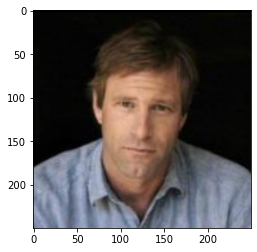

Hello, human!
If you were a dog... You look like a Beauceron


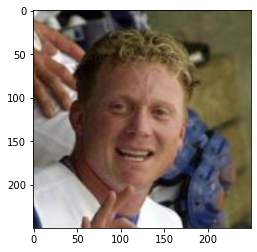

Hello, human!
If you were a dog... You look like a Dogue de bordeaux


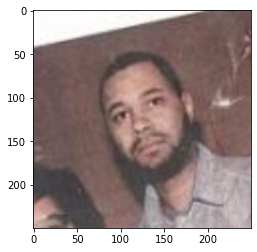

Hello, human!
If you were a dog... You look like a Chinese crested


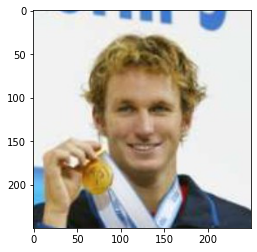

Hello, human!
If you were a dog... You look like a Australian shepherd


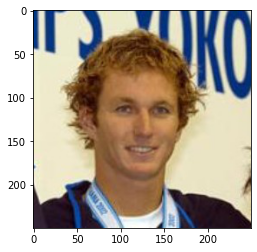

Hello, human!
If you were a dog... You look like a Dachshund


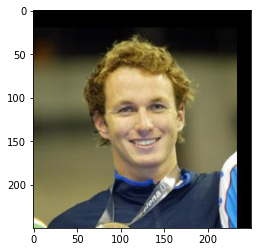

Hello, human!
If you were a dog... You look like a Beagle


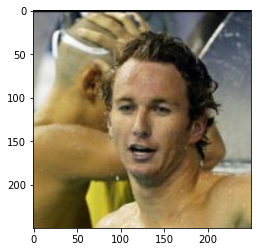

Hello, human!
If you were a dog... You look like a Dogue de bordeaux


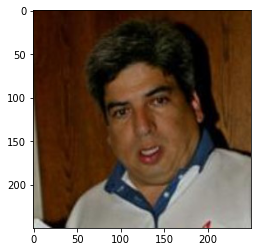

Hello, human!
If you were a dog... You look like a Basenji


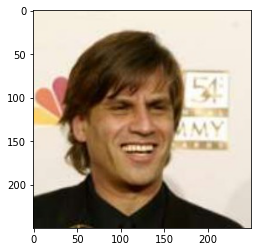

Hello, human!
If you were a dog... You look like a Dachshund


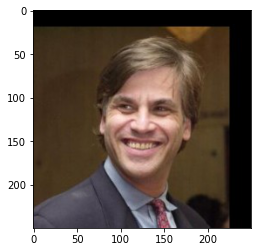

Hello, human!
If you were a dog... You look like a Clumber spaniel


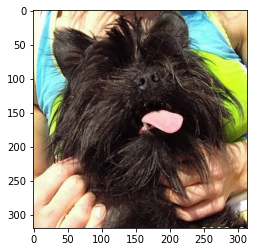

Dog Detected!
It looks like a Affenpinscher


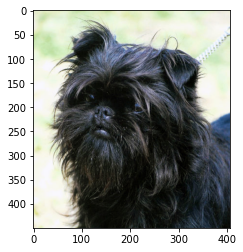

Dog Detected!
It looks like a Affenpinscher


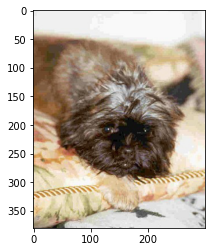

Dog Detected!
It looks like a Brussels griffon


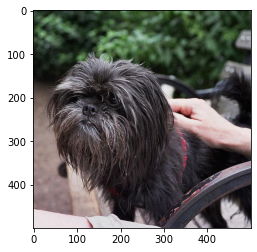

Dog Detected!
It looks like a Affenpinscher


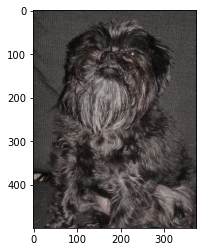

Dog Detected!
It looks like a Affenpinscher


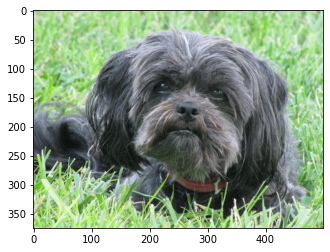

Dog Detected!
It looks like a Lhasa apso


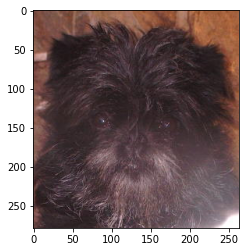

Dog Detected!
It looks like a Affenpinscher


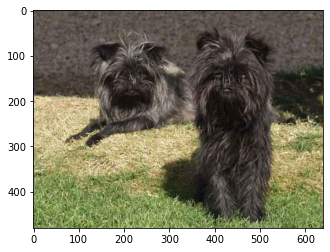

Dog Detected!
It looks like a Affenpinscher


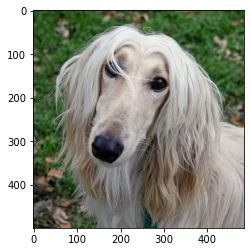

Dog Detected!
It looks like a Afghan hound


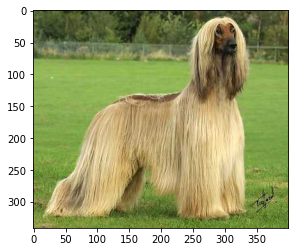

Dog Detected!
It looks like a Afghan hound


In [38]:
for file in np.hstack((human_files[:10], dog_files[:10])):
    run_app(file)